In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
from scipy.spatial import distance
import time
import warnings
import scanpy as sc
import anndata
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = 6, 6.5
import harmonypy as hm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\11360\anaconda3\envs\bio\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
ad2 = sc.read('./retina_20211001_raw.h5')

In [3]:
ad2 = ad2[:,~ad2.var_names.str.startswith('ERCC')]

In [4]:
ad2.var_names = ad2.var_names.str.split('_').str[1]

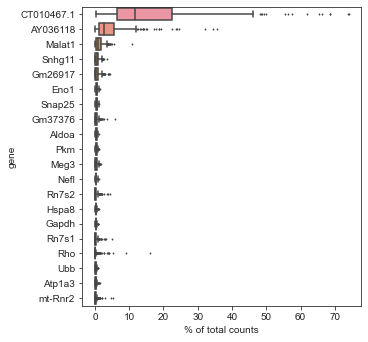

In [5]:
sc.pl.highest_expr_genes(ad2, n_top=20, )

In [6]:
ad2.var_names_make_unique()

In [7]:
sc.pp.filter_cells(ad2, min_genes=200)
sc.pp.filter_genes(ad2, min_cells=3)

In [8]:
sc.pp.normalize_total(ad2, target_sum=1e4)
sc.pp.log1p(ad2)

Populating the interactive namespace from numpy and matplotlib


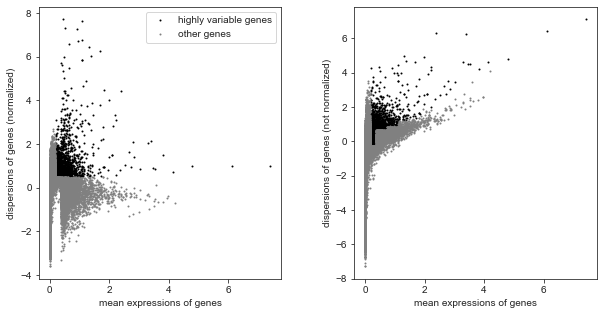

# HVG: 3629


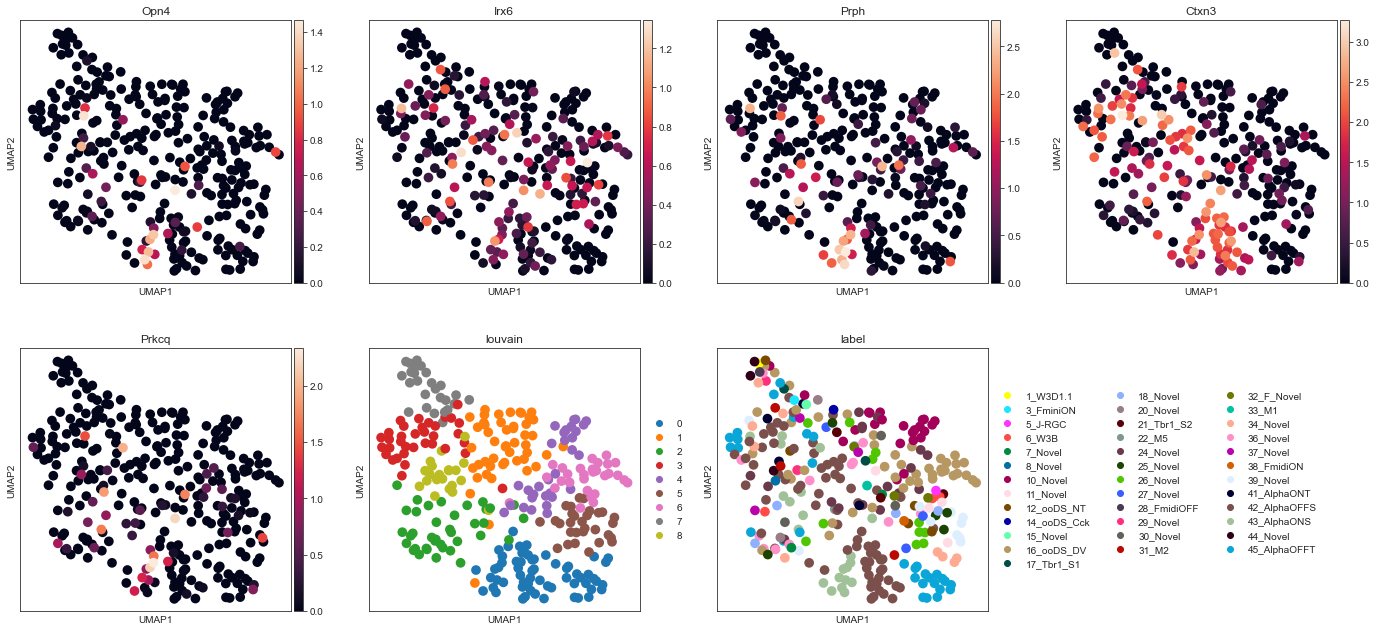

In [9]:
%pylab inline
figsize(5,5)

sc.pp.highly_variable_genes(ad2, min_mean=0.18, max_mean=20, min_disp=0.5)
sc.pl.highly_variable_genes(ad2)
print('# HVG: %d'%ad2.var['highly_variable'].sum())
sc.tl.pca(ad2, n_comps=50,use_highly_variable = True)
sc.pp.neighbors(ad2)
sc.tl.umap(ad2)

sc.tl.louvain(ad2,resolution=1.5)
sc.pl.umap(ad2, color = ['Opn4','Irx6','Prph','Ctxn3','Prkcq','louvain','label'])

In [10]:
ad1 = sc.read("./RGC_org_reference.h5")

In [11]:
all(ad2.obs['label'].isin(ad1.obs['org_cluster'].cat.categories))

True

# Change color

In [12]:
# ooDSGCs 
ad1.uns['org_cluster_colors'][11]='#FFB307'
ad1.uns['org_cluster_colors'][15]='#D6C300'
ad1.uns['org_cluster_colors'][9]='#FF9F2C'
ad1.uns['org_cluster_colors'][23]='#E2943B'
# Tusc5-RGCs famliy 
ad1.uns['org_cluster_colors'][0]='#F77790'
ad1.uns['org_cluster_colors'][12]='#F9AD86'
ad1.uns['org_cluster_colors'][1]='#FF4FC4'
ad1.uns['org_cluster_colors'][5]='#E37D92'
ad1.uns['org_cluster_colors'][22]='#FBA28B' 
ad1.uns['org_cluster_colors'][29]='#F5348A'
# F-RGCs famliy  
ad1.uns['org_cluster_colors'][2]='#00A809'
ad1.uns['org_cluster_colors'][3]='#669D6A'
ad1.uns['org_cluster_colors'][27]='#005C07'
ad1.uns['org_cluster_colors'][37]='#0C8918'
ad1.uns['org_cluster_colors'][31]='#179930'
# alpha-RGCs famliy  
ad1.uns['org_cluster_colors'][41]='#9440F3'
ad1.uns['org_cluster_colors'][44]='#AC9FF0'
ad1.uns['org_cluster_colors'][40]='#7000AA'
ad1.uns['org_cluster_colors'][42]='#7044AA'
#T-RGCs
ad1.uns['org_cluster_colors'][4]='#973C5C'
ad1.uns['org_cluster_colors'][8]='#A30826' 
ad1.uns['org_cluster_colors'][16]='#C0242E'
ad1.uns['org_cluster_colors'][20]='#BC4B11' 

# ipRGCs famliy 
ad1.uns['org_cluster_colors'][30]='#74CAFF'
ad1.uns['org_cluster_colors'][32]='#69A8E6'
ad1.uns['org_cluster_colors'][39]='#578EBF'
ad1.uns['org_cluster_colors'][21]='#2578B5'
# other famliy 
ad1.uns['org_cluster_colors'][6]='#BD8754'
ad1.uns['org_cluster_colors'][7]='#67420E'
ad1.uns['org_cluster_colors'][14]='#997D87'
ad1.uns['org_cluster_colors'][17]='#E5CD53'
ad1.uns['org_cluster_colors'][10]='#B3B561'
ad1.uns['org_cluster_colors'][13]='#E0D394'
ad1.uns['org_cluster_colors'][26]='#F77790'
ad1.uns['org_cluster_colors'][33]='#BB3E44'
ad1.uns['org_cluster_colors'][35]='#A44669'
ad1.uns['org_cluster_colors'][36]='#BA0C88'
ad1.uns['org_cluster_colors'][43]='#FF4FC4'
# N-RGCs famliy 

ad1.uns['org_cluster_colors'][18]='#1B4400'
ad1.uns['org_cluster_colors'][19]='#4FC601'
ad1.uns['org_cluster_colors'][24]='#668751'
ad1.uns['org_cluster_colors'][25]='#A7AE5A'
ad1.uns['org_cluster_colors'][28]='#DEE570'
ad1.uns['org_cluster_colors'][34]='#93CDA0'
ad1.uns['org_cluster_colors'][38]='#78552E'

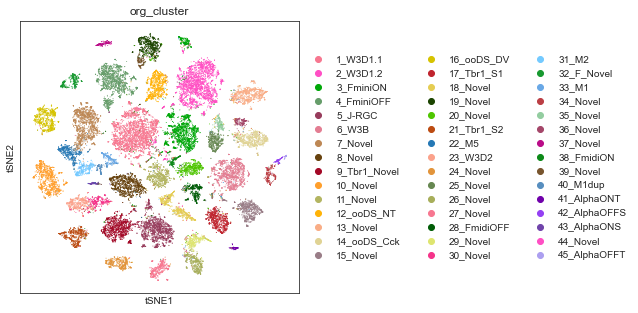

In [13]:
sc.pl.tsne(ad1,color='org_cluster')

In [14]:
def get_map10x_umap(anndata_tran10X,anndata_patchSeq,embeddingType='X_umap',knn=15,distMetric = 'correlation',isPlot = True,NN = 0,cluster_10x = 'org_cluster',patchSeq_cluster='100th_label',use_family=None):
    import numpy as np
    family_dict=dict()
    family_dict['ooDSGCs']=['12_ooDS_NT','16_ooDS_DV','10_Novel','24_Novel']
    family_dict['TW']=['1_W3D1.1', '2_W3D1.2', '6_W3B','13_Novel','23_W3D2','30_Novel']
    family_dict['F_RGC']=['3_FminiON','4_FminiOFF','28_FmidiOFF','32_F_Novel','38_FmidiON']
    family_dict['T-RGCs']=['5_J-RGC','9_Tbr1_Novel','17_Tbr1_S1','21_Tbr1_S2']
    family_dict['ipRGC']=['40_M1dup','31_M2','33_M1', '22_M5']
    family_dict['alpha']=['41_AlphaONT', '42_AlphaOFFS', '43_AlphaONS','45_AlphaOFFT']
    family_dict['N_RGC']=['19_Novel', '20_Novel','25_Novel','26_Novel','29_Novel','35_Novel','39_Novel']
    family_dict['Other']=['11_Novel','14_ooDS_Cck','15_Novel','18_Novel','27_Novel','34_Novel','36_Novel','37_Novel','44_Novel','7_Novel','8_Novel']
    if use_family == None:
        tran10X=anndata_tran10X
        patchSeq=anndata_patchSeq
    else:
        tran10X=anndata_tran10X[anndata_tran10X.obs[cluster_10x].isin(family_dict[use_family]),]
        tran10X=family_reumap(tran10X,use_family)
        patchSeq=anndata_patchSeq[anndata_patchSeq.obs[patchSeq_cluster].isin(family_dict[use_family]),]
            
    clusterIDs10X=np.array([n for n in tran10X.obs[cluster_10x].cat.categories])
    clusterIDs10X
    cluster10X_colors = list(tran10X.uns[cluster_10x+'_colors'])
    patchGenes = patchSeq.var_names
    referenceGenes = tran10X.var_names[tran10X.var['highly_variable']]
    commenSet = sorted(list(set(referenceGenes) & set(patchGenes)))
    print(str(len(commenSet))+' commen gene')
    assignmentPositions = np.zeros((patchSeq.shape[0], 2))
    assignmentPositions.shape
    for i in enumerate(patchSeq.obs_names):
            anDataObj_set=tran10X[tran10X.obs[cluster_10x]==patchSeq.obs[patchSeq_cluster][i[1]],commenSet]
            referenceLogCPM =anDataObj_set.X
            referenceAtlas = anDataObj_set.obsm[embeddingType] ## use tsne from scanpy
            newLogCPM = patchSeq[i[1],commenSet].X
            #print(newLogCPM.shape)
            dist = distance.cdist(newLogCPM, referenceLogCPM, distMetric)
            #print(dist.shape)
            ind = np.argsort(dist)[:, :knn]
            #print(ind[0,:])
            #print(referenceAtlas[ind[0,:],:])
            #print(np.median(referenceAtlas[ind[0,:],:], axis=0))
            assignmentPositions[i[0],:] = np.median(referenceAtlas[ind[0,:],:], axis=0)
    patch_map = pd.DataFrame(assignmentPositions)
    patch_map.index = patchSeq.obs_names
    patch_map.columns=['X','Y']
    return patch_map

In [15]:
def plot_map_10x_type(patch_map,color_dic,anndata_tran10X,embeddingType='X_umap',cluster_10x = 'org_cluster',cell_info='cell_info',morphology_type='size',use_family=None,map_type='None'):
    family_dict=dict()
    family_dict['ooDSGCs']=['12_ooDS_NT','16_ooDS_DV','10_Novel','24_Novel']
    family_dict['TW']=['1_W3D1.1', '2_W3D1.2', '6_W3B','13_Novel','23_W3D2','30_Novel']
    family_dict['F_RGC']=['3_FminiON','4_FminiOFF','28_FmidiOFF','32_F_Novel','38_FmidiON']
    family_dict['T-RGCs']=['5_J-RGC','9_Tbr1_Novel','17_Tbr1_S1','21_Tbr1_S2']
    family_dict['ipRGC']=['40_M1dup','31_M2','33_M1', '22_M5']
    family_dict['alpha']=['41_AlphaONT', '42_AlphaOFFS', '43_AlphaONS','45_AlphaOFFT']
    family_dict['N_RGC']=['19_Novel', '20_Novel','25_Novel','26_Novel','29_Novel','35_Novel','39_Novel']
    family_dict['Other']=['11_Novel','14_ooDS_Cck','15_Novel','18_Novel','27_Novel','34_Novel','36_Novel','37_Novel','44_Novel','7_Novel','8_Novel']
    if use_family == None:
        tran10X=anndata_tran10X
    else:
        tran10X=anndata_tran10X[anndata_tran10X.obs[cluster_10x].isin(family_dict[use_family]),]
        tran10X=family_reumap(tran10X,use_family)
    referenceAtlas=tran10X.obsm[embeddingType]
    cell_info_series = cell_info[morphology_type]
    if type(cell_info_series[1]) != str:
        cell_info_series=cell_info_series[~(cell_info_series=='Unk')]
        print(cell_info_series)
        morphology_type_list =[]         #asymmetry was enluminated by dot size
        color_list =[]            # no morphology cell colored green else red
        for i in patch_map.index:
            if i in cell_info_series.index:
                if cell_info_series.median()>4000:
                    morphology_type_list.append(cell_info_series[i]/500)
                else:
                    morphology_type_list.append(cell_info_series[i])
                color_list.append('r')
            else:
                morphology_type_list.append(2)
                color_list.append('g')
        plt.figure(figsize=(10,10))
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.scatter(referenceAtlas[:,0], referenceAtlas[:,1], s=1, color=[.8,.8,.8])
        plt.scatter(patch_map.iloc[:,0], patch_map.iloc[:,1], s=morphology_type_list, c=color_list, edgecolors='k')
        plt.title(f'Patch-seq data mapping family={use_family},map type={map_type}')
        plt.gca().get_xaxis().set_ticklabels([])
        plt.gca().get_yaxis().set_ticklabels([])
        plt.tight_layout()
        plt.savefig(f'./family={use_family},map type={map_type}.pdf')
    else:
        #cell_info_series_type = cell_info_series.astype('category').cat.categories
        #manual define color_dic
        print(color_dic)
        morphology_type_list =[]         #asymmetry was enluminated by dot size
        color_list =[]            # no morphology cell colored green else red
        for i in patch_map.index:
            if cell_info_series[i] !='Unk':
                morphology_type_list.append(80)
                color_list.append(color_dic.get(cell_info_series[i]))
            else:
                morphology_type_list.append(35)
                color_list.append(color_dic.get(cell_info_series[i]))
        
        plt.figure(figsize=(10,10))
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.scatter(referenceAtlas[:,0], referenceAtlas[:,1], s=1, color=[.8,.8,.8])
        plt.scatter(patch_map.iloc[:,0], patch_map.iloc[:,1], s=morphology_type_list, c=color_list, edgecolors='k')
        counter=0
        for i in set(cell_info_series):
            plt.scatter(13,18+counter,s=50,c=color_dic[i])
            plt.text(13.5,18+counter,': '+i)
            counter+=0.6
        plt.title(f'Patch-seq data mapping family={use_family},map type={map_type}')
        plt.text(2,10,use_family,fontsize=13,fontweight='bold')
        if use_family is None:
            pass
        else:
            counter = 0
            for i in family_dict[use_family]:
                plt.text(8,15+counter,i,color='grey')
                counter+=0.6
        plt.gca().get_xaxis().set_ticklabels([])
        plt.gca().get_yaxis().set_ticklabels([])
        plt.tight_layout()
        plt.savefig(f'./family={use_family},map type={map_type}.pdf')
        #plt.savefig(f'./family={use_family},map type={map_type}.jpg')

In [16]:
patchmap = get_map10x_umap(ad1 ,ad2,embeddingType='X_tsne',cluster_10x = 'org_cluster',patchSeq_cluster='label',use_family=None)

4400 commen gene


In [17]:
color_dic = dict(zip(ad1.obs['org_cluster'].cat.categories,ad1.uns['org_cluster_colors'])) ## obtain oringnal 10X umap color

In [18]:
color_10x = [color_dic.get(i) for i in ad1.obs['org_cluster']]

In [27]:
referenceAtlas=ad1.obsm['X_tsne']

In [28]:
mor_dic = dict()
mor_dic['ON']="#228B22"
mor_dic['OFF']="#9400D3"
mor_dic['ON-OFF']="#DB214C"
mor_dic['Unk']="#B4B4B4"

In [29]:
marker_dic=dict()
marker_dic['ON']='s'
marker_dic['OFF']='P'
marker_dic['ON-OFF']='^'
marker_dic['Unk']='o'

In [30]:
sort_value_index = dict()
sort_value_index['ON']=3
sort_value_index['OFF']=4
sort_value_index['ON-OFF']=2
sort_value_index['Unk']=1

In [31]:
patch_size=[]
patch_marker=[]
sort_value=[]
for i in ad2.obs.index:
    patch_marker.append(marker_dic.get(ad2.obs.loc[i,'Blue_light_response']))
    sort_value.append(sort_value_index.get(ad2.obs.loc[i,'Blue_light_response']))
    if ad2.obs.loc[i,'Blue_light_response'] == 'Unk':
        patch_size.append(15)
    elif ad2.obs.loc[i,'Blue_light_response'] == 'OFF':
        patch_size.append(65)
    elif ad2.obs.loc[i,'Blue_light_response'] == 'ON-OFF':
        patch_size.append(65)
    elif ad2.obs.loc[i,'Blue_light_response'] == 'ON':
        patch_size.append(45)

In [32]:
patchmap['light_reslabel']=ad2.obs['Blue_light_response']
patchmap['plot_size']=patch_size

In [33]:
patchmap['plot_marker']=patch_marker
patchmap['plot_sort_value']=sort_value

In [34]:
plot_index = patchmap['plot_sort_value'].sort_values().index

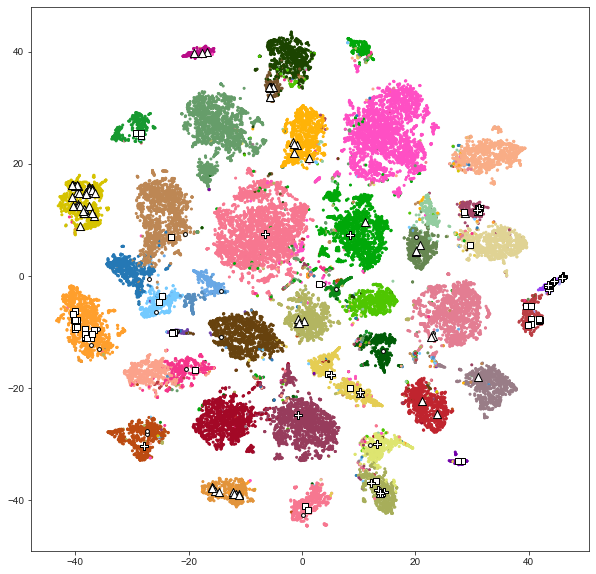

In [42]:
type_color=dict()
type_color['+']='black'
figsize(10,10)
plt.scatter(referenceAtlas[:,0], referenceAtlas[:,1], s=4, color=color_10x)
for i in plot_index:
    plt.scatter(patchmap.loc[i,'X'], patchmap.loc[i,'Y'], s=patchmap.loc[i,'plot_size'], c=type_color.get(patchmap.loc[i,'plot_marker'],'white'),marker=patchmap.loc[i,'plot_marker'],edgecolors=['black' if patchmap.loc[i,'plot_marker']!="+" else None])
plt.savefig('./figures/fig2a_tsne.pdf')

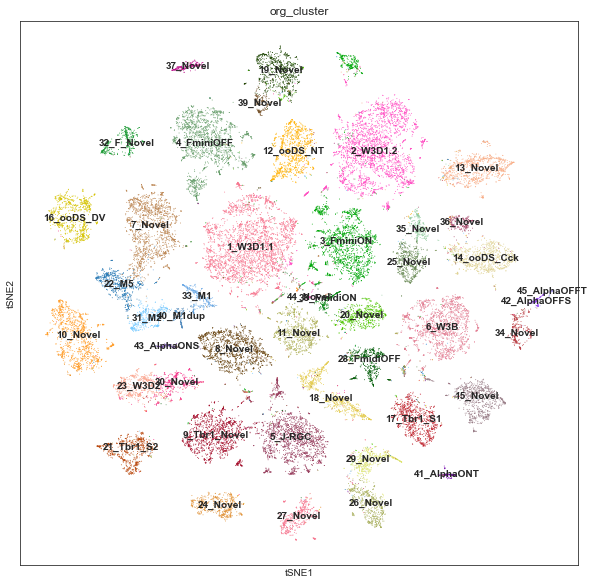

In [40]:
sc.pl.tsne(ad1,color='org_cluster',legend_loc = 'on data',save='org_reference_tsne.pdf')

In [33]:
ad2.obs['label'][301]

'5_J-RGC'

In [36]:
patchmap.loc['R945_FKDL202628606-1a_HNTL7DSXY_L4',:]

X                  1.365066
Y                  5.862596
light_reslabel          OFF
plot_size                65
plot_marker               P
plot_sort_value           4
Name: R945_FKDL202628606-1a_HNTL7DSXY_L4, dtype: object

In [35]:
ad2.obs_names[301]

'R945_FKDL202628606-1a_HNTL7DSXY_L4'

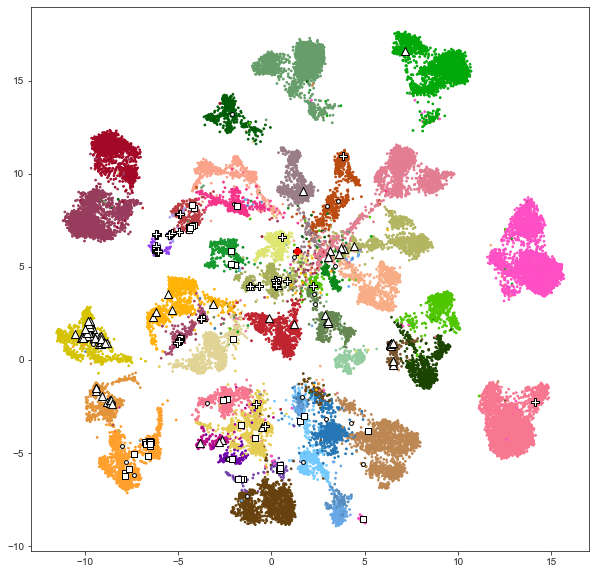

In [37]:
type_color=dict()
type_color['+']='black'
figsize(10,10)
plt.scatter(referenceAtlas[:,0], referenceAtlas[:,1], s=3, color=color_10x)
for i in plot_index:
    plt.scatter(patchmap.loc[i,'X'], patchmap.loc[i,'Y'], s=patchmap.loc[i,'plot_size'], c=type_color.get(patchmap.loc[i,'plot_marker'],'white'),marker=patchmap.loc[i,'plot_marker'],edgecolors=['black' if patchmap.loc[i,'plot_marker']!="+" else None])
plt.scatter(1.365066,5.862596,c='red')
#plt.savefig('./figures/fig2a_umap.pdf')

In [28]:
ad2.write('./retina_patchseq.h5')

In [ ]:
ad2 = sc.read('./retina_patchseq.h5')